# Halving the ABA

In [39]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
from sklearn.preprocessing import StandardScaler
%matplotlib inline
%run nifti_tools.ipynb

In [3]:
# Checking the dimensions in clusters
clusters = np.load('/data/bioprotean/ABA/PCA/80_variance/Kmeans_labels/100_clusters.npy')

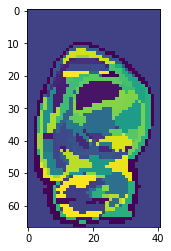

In [7]:
component = clusters[:,15,:]
plt.imshow(component)

# 58 / 2 = 29 kept from second dimension!

In [9]:
# Loading the full matrix
full_genes = np.memmap('/data/bioprotean/ABA/MEMMAP/genes_list/finalgenes_T.mymemmap',\
dtype='float32', mode='r', shape=(159326,2941))

In [11]:
# Loading the Neuroanatomy
anat_path = '/data/bioprotean/ABA/PCA/80_variance/allen_annot200.nii'
anat_vec = nifti_to_vector(anat_path)

In [13]:
# 3Dizing the Neuroanatomy
anat_3D = anat_vec.reshape(67,58,41)

In [17]:
# Halving by Neuroanatomy
anat_half = np.zeros_like(anat_3D)
anat_half[:,:29,:] = anat_3D[:,:29,:]

In [29]:
# Vectorized
anat_half_vec = anat_half.flatten()

In [30]:
# Getting indices of non-zero values
half_indices = np.nonzero(anat_half_vec)
anat_half_masked = anat_half_vec[half_indices]

In [31]:
# Saving indices to file
np.save('/data/bioprotean/ABA/MEMMAP/genes_list/half_indices.npy', half_indices)

In [34]:
# Making a new array to save
save_arr = np.zeros((31512,2941))

In [35]:
for i in range(2941):
    save_arr[:,i] = full_genes[half_indices,i]

In [37]:
# Saving the half and masked genes to file
np.save('/data/bioprotean/ABA/MEMMAP/genes_list/genes_half_masked.npy', save_arr)

In [38]:
# Keeping positive values
half_mask_pos = np.where(save_arr < 0, 0, save_arr)

In [40]:
# Standardizing the matrix
half_mask_pos_std = StandardScaler().fit_transform(half_mask_pos)

np.save('/data/bioprotean/ABA/MEMMAP/genes_list/genes_half_mask_pos_std.npy',\
half_mask_pos_std)

In [41]:
# L2 normalizing the matrix
x_norm = normalize(half_mask_pos, norm='l2', axis=1, copy=True)

np.save('/data/bioprotean/ABA/MEMMAP/genes_list/genes_half_mask_pos_L2.npy',\
x_norm)

In [42]:
x_norm.shape

(31512, 2941)

In [ ]:
def reconstruct_half_ABA (vector, array_3D = False):
    '''
    This function reconstructs the masked and halved
    vector to the original shape (159326,).
    
    Args:
        vector: vec
            The masked vector
        array: bool, default = False
            if True, an array of size (67,58,41) is returned.
    
    Returns:
        output: array
            output vector/array
    '''
    
    # Loading the indices from file
    indices = np.load('/data/bioprotean/ABA/MEMMAP/genes_list/half_indices.npy')
    
    # Reconstructing the array
    output = np.zeros(159326,)
    output[indices] = vector
    
    # If 3D array is favored
    if array_3D == True:
        output = output.reshape(67,58,41)
    
    return output